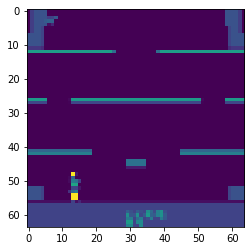

In [17]:
import supersuit as ss
from stable_baselines3 import PPO, DQN
# from stable_baselines3.deepq.policies import CnnPolicy
import numpy as np

from pettingzoo.atari import mario_bros_v3,space_invaders_v2
import matplotlib.pyplot as plt

env = space_invaders_v2.env()


# env = ss.observation_lambda_v0(env, lambda obs,obs_space: obs[25:195,:,:], lambda obs_space:obs_space)
# env = ss.color_reduction_v0(env, mode="B")
# env = ss.resize_v1(env, x_size=64, y_size=64)
# # env = ss.frame_stack_v1(env, 4)
# env.reset()
# for i in range(1000):
    # o,r,d,i = env.last()
#     env.step(0)
#     if(r != 0 or len(i) != 0):
#         print(f"{r=},{i=}")
#     env.render()

env = mario_bros_v3.env()
env = ss.observation_lambda_v0(env, lambda obs,obs_space: obs[25:195,:,:], lambda obs_space:obs_space)
env = ss.color_reduction_v0(env, mode="B")
env = ss.resize_v1(env, x_size=64, y_size=64)
# env = ss.action_lambda_v1(env,lambda action, act_space : actChange(action), lambda act_space : gym.spaces.Discrete(7))
# env = ss.frame_stack_v1(env, 4)
# env = ss.black_death_v3(env)
# env = ss.pettingzoo_env_to_vec_env_v1(env)
# env = ss.concat_vec_envs_v1(env, 2, num_cpus=1, base_class="stable_baselines3")

env.reset()
env.step(0)
o,r,d,i = env.last()

plt.imshow(o)

# env = ss.black_death_v3(env)
# env = ss.pettingzoo_env_to_vec_env_v1(env)
# env = ss.concat_vec_envs_v1(env, 2, num_cpus=1, base_class="stable_baselines3")

